In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button
from matplotlib import cm
from matplotlib.patches import Circle
from astropy import units as u
from astropy import constants as const
from jupyterthemes import jtplot #These two lines can be skipped if you are not using jupyter themes
jtplot.reset()
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=67.4, Om0=0.314)
import time
start_total = time.time()
from plasma_jet_class import sieplasmajet
import warnings
warnings.filterwarnings('ignore')
import contextlib
import io
import sys

%matplotlib notebook

In [2]:
zl = 0.2; zs = 1.2

Dl = cosmo.angular_diameter_distance(zl)   
Ds = cosmo.angular_diameter_distance(zs)    
Dls = cosmo.angular_diameter_distance_z1z2(zl, zs)

print('Dl: ',Dl); print('Ds: ',Ds); print('Dls: ',Dls)
print('G: ',(const.G).value ,(const.G).unit)
G = const.G
rho_crit = (cosmo.critical_density(zl)).to(u.kg/u.m**3)
print('rho_crit :',rho_crit)
c_light = (const.c).to(u.cm/u.second)
print('c_light :', c_light)

#r0 = 10*u.kpc
r0 = 10.0*u.kpc
#r0 = 0.1*u.kpc
print('r0:', r0)
pi = np.pi

def scale_radius(v,Dl,Ds,Dls):                               #this is e0 in eq 3.42 meneghetti, eq 1 barnacka 2014
    return (4.*pi*v**2/c_light**2*Dl*Dls/Ds).decompose()
def theta_E_SIS():
    'in arcsec'
    pre_theta_E = (scale_radius(v,Dl,Ds,Dls)/Dl).decompose()
    return pre_theta_E*u.rad.to('arcsec', equivalencies=u.dimensionless_angles())

v = 180 *u.km/u.s
ss_r = scale_radius(v,Dl,Ds,Dls) 
print('scale radius (m): ',ss_r)
print('scale radius (kpc): ',ss_r.to(u.kpc))
print('theta_E_g: ',theta_E_SIS() ,'arcsec')

theta_E_g = theta_E_SIS()
elipt = eta = 0.3
re = (const.e.esu**2/const.m_e/(c_light**2)).decompose()
print('Classic electron radius: ',re)

Dl:  705.4019455128785 Mpc
Ds:  1760.3796178766652 Mpc
Dls:  1375.6149203241862 Mpc
G:  6.6743e-11 m3 / (kg s2)
rho_crit : 1.0483397591328813e-26 kg / m3
c_light : 29979245800.0 cm / s
r0: 10.0 kpc
scale radius (m):  7.705329461274929e+19 m
scale radius (kpc):  2.49712721364453 kpc
theta_E_g:  0.7301786792241515 arcsec
Classic electron radius:  2.817940324670788e-15 m


In [3]:
theta_0 = (r0/Dl).decompose()*u.rad.to('arcsec', equivalencies=u.dimensionless_angles()) 
print('Angular scale radius (theta_0 = r0/Dl): ',theta_0, 'arcsec')

Angular scale radius (theta_0 = r0/Dl):  2.9240748137875747 arcsec


In [4]:
A = 2.00744300029693
B = 1.5887225542022732
C = 1.4308204791467736

phi = np.linspace(0,2*np.pi, 3000)

In [5]:
n0 = 300./(u.cm)**(3)
w_p = np.sqrt(n0*const.e.si**2 / const.m_e  /const.eps0 )
f_p = 1/2/np.pi*w_p
f_p.to('MHz')

<Quantity 0.155515 MHz>

<IPython.core.display.Javascript object>


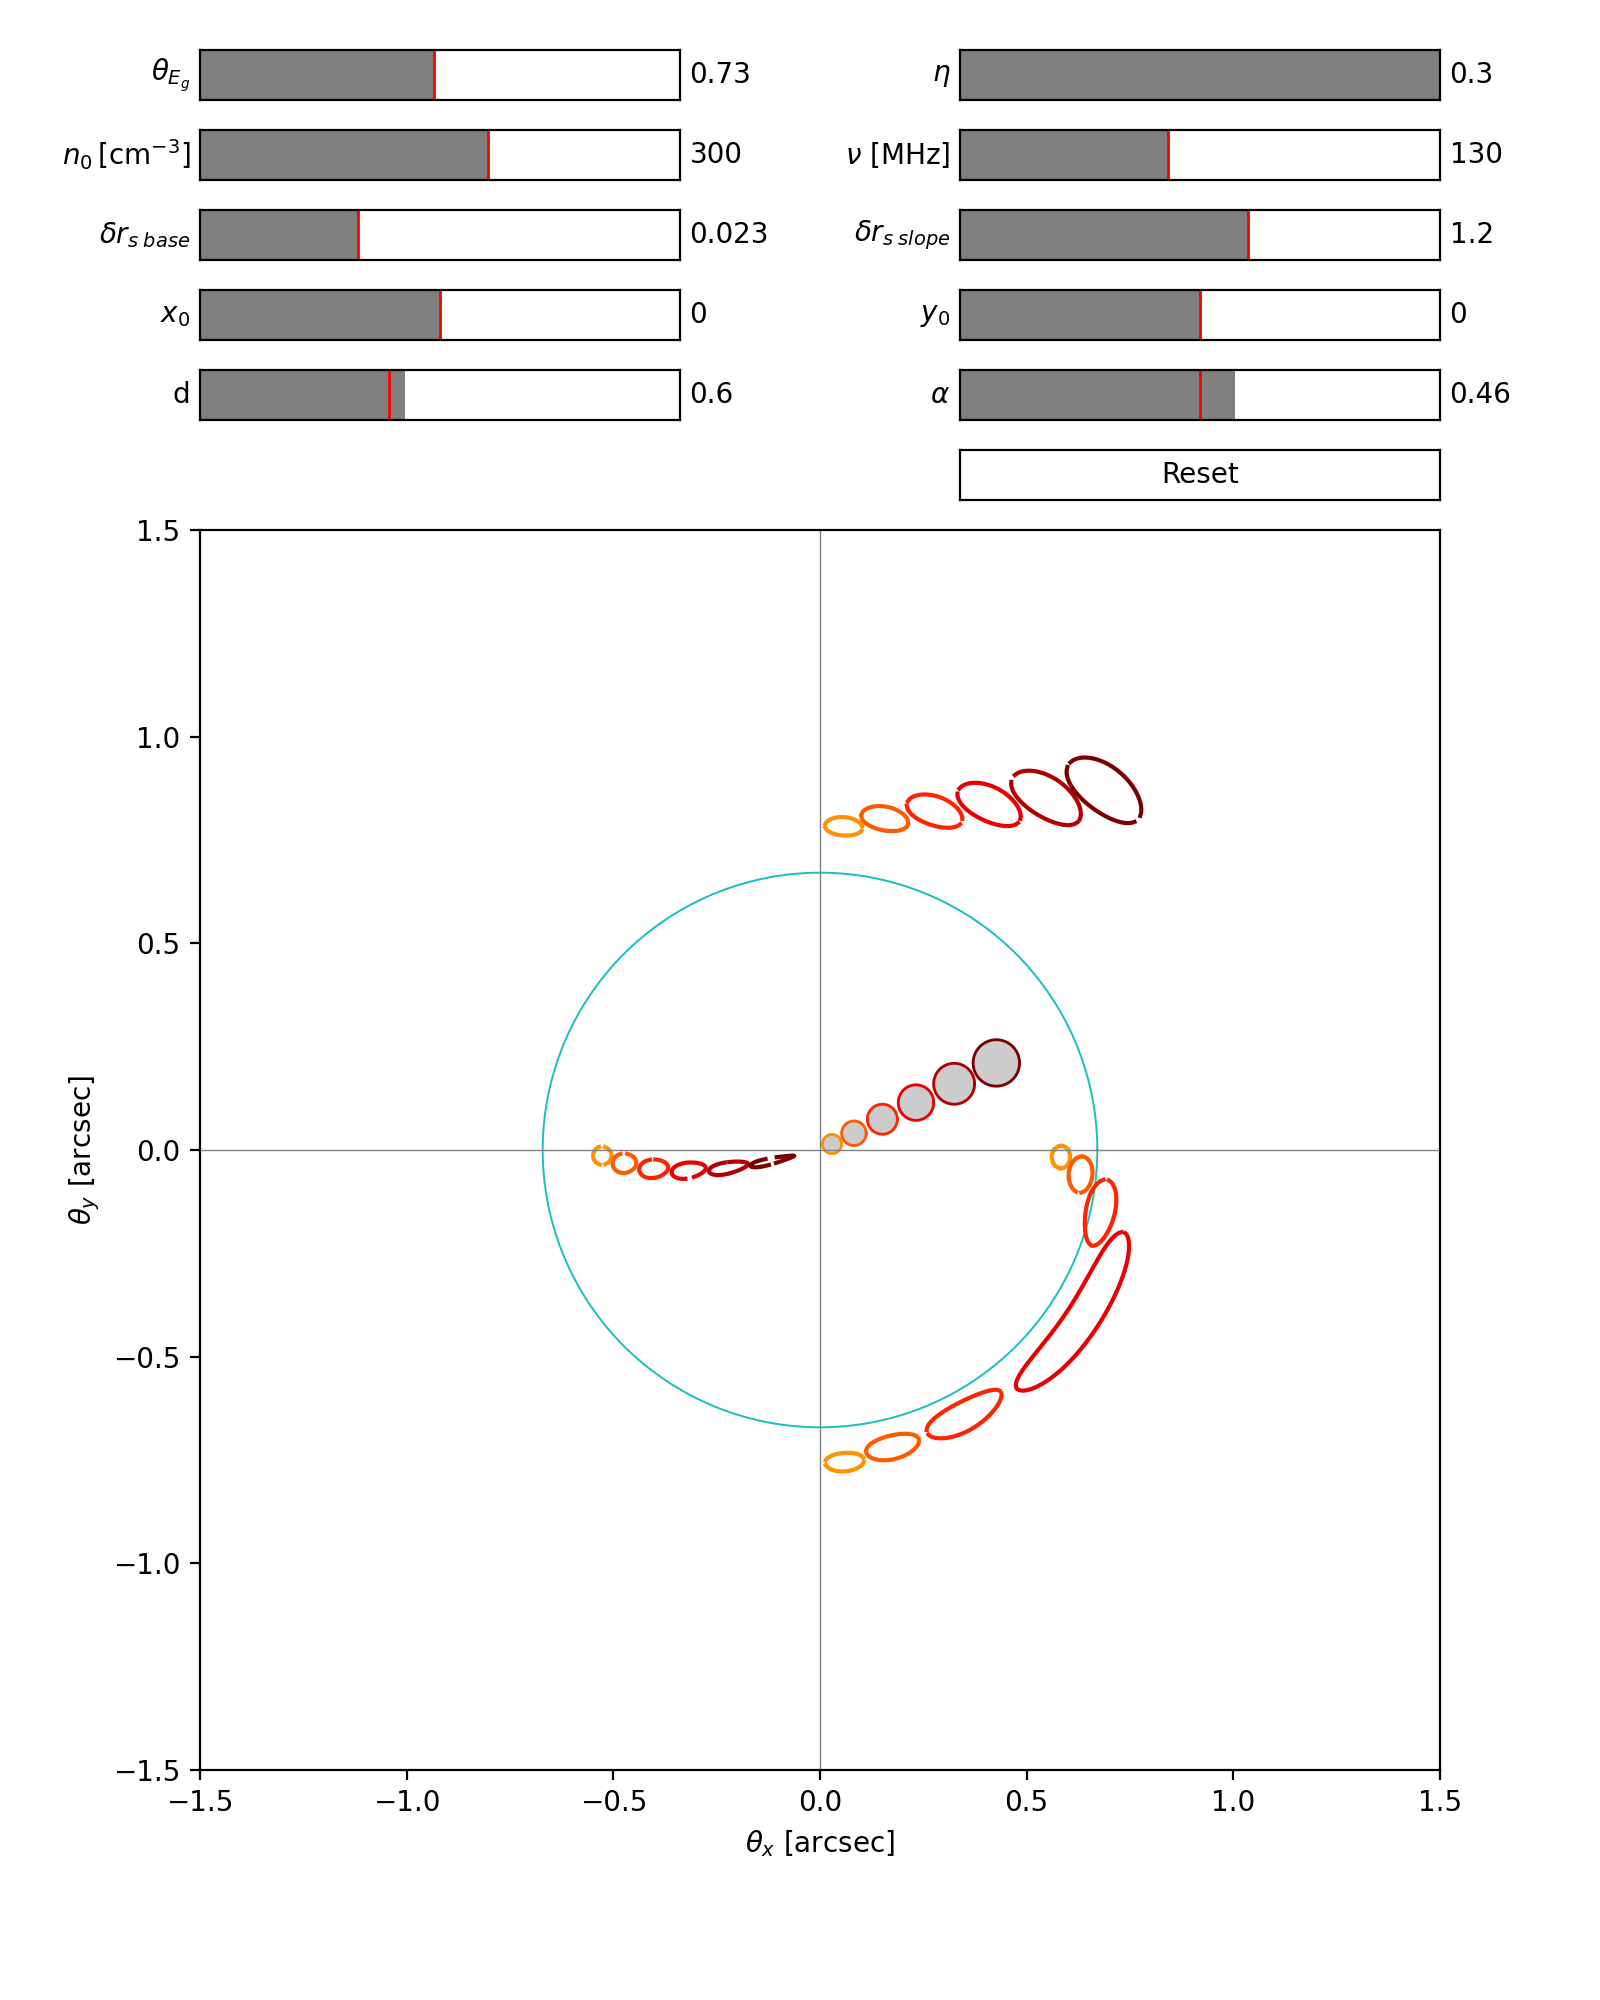

In [6]:
fig = plt.figure(figsize=(8, 10),num="LENSTOMI3")
ax = fig.add_subplot(111)
fig.subplots_adjust(bottom=0.1, top=0.75)

hot = cm.get_cmap('hot', 13)

ax.set_xlim([-1.5, 1.5])
ax.set_ylim([-1.5, 1.5])

plt.gca().set_aspect('equal', adjustable='box')

ax_theta_E_g = fig.add_axes([0.125, 0.95, 0.3, 0.025])
ax_eta = fig.add_axes([0.6, 0.95, 0.3, 0.025])
ax_n0 = fig.add_axes([0.125, 0.91, 0.3, 0.025])
ax_nu = fig.add_axes([0.6, 0.91, 0.3, 0.025])
ax_a = fig.add_axes([0.125, 0.87, 0.3, 0.025])
ax_b = fig.add_axes([0.6, 0.87, 0.3, 0.025])
ax_c1 = fig.add_axes([0.125, 0.83, 0.3, 0.025])
ax_c2 = fig.add_axes([0.6, 0.83, 0.3, 0.025])
ax_d = fig.add_axes([0.125, 0.79, 0.3, 0.025])
ax_alpha = fig.add_axes([0.6, 0.79, 0.3, 0.025])
resetax = plt.axes([0.6, 0.75, 0.3, 0.025])

button = Button(resetax, 'Reset', color='white', hovercolor='0.975')
s_theta_E_g = Slider(ax=ax_theta_E_g, label=r'$\theta_{E_{g}}$', valmin=0, valmax=1.5,valinit = 0.73,
              valfmt='%1.2g', facecolor='grey')
s_eta = Slider(ax=ax_eta,label= r'$\eta$', valmin=0, valmax=0.3, 
             valinit=0.3, valfmt='%3.2g', facecolor='grey')
s_n0 = Slider(ax=ax_n0,label= '$n_0 \, [\mathrm{cm}^{-3}] $', valmin=0, valmax=500, 
             valinit=300, valfmt='%i', facecolor='grey')
s_nu = Slider(ax=ax_nu,label= r'$\nu$ [MHz]', valmin=0, valmax=300, 
             valinit=130, valfmt='%i', facecolor='grey')
s_a = Slider(ax=ax_a,label= '$\delta r_{s\; base}$', valmin=0, valmax=0.07, 
             valinit=0.023, valfmt='%1.2g', facecolor='grey')
s_b = Slider(ax=ax_b,label= '$\delta r_{s\; slope}$', valmin=0, valmax=2, 
             valinit=1.2, valfmt='%1.2g', facecolor='grey')
s_c1 = Slider(ax=ax_c1,label= r'$x_0$', valmin=-0.2, valmax=0.2, 
             valinit=0, valfmt='%1.2g', facecolor='grey')
s_c2 = Slider(ax=ax_c2,label= r'$y_0$', valmin=-0.2, valmax=0.2, 
             valinit=0, valfmt='%1.2g', facecolor='grey')
s_d = Slider(ax=ax_d,label= 'd', valmin=0, valmax=1.4, 
             valinit=.55, valfmt='%1.2g', facecolor='grey')
s_alpha = Slider(ax=ax_alpha,label= r'$\alpha$', valmin=-np.pi, valmax=np.pi, 
             valinit=0, valfmt='%1.2g', facecolor='grey')

eta = 0.3
nu = 130.0 * u.MHz
omega = nu*(1.+zl)*2*np.pi
n0 = 300./(u.cm)**(3)
psi0_plasma = (A*Dls/Ds/Dl*2*pi*c_light**2/omega**2*re*n0*r0 \
            *(u.rad**2).to('arcsec**2', equivalencies=u.dimensionless_angles()) ).decompose()
psi0_plasma_num = psi0_plasma.value
theta_E_g = theta_E_SIS().value
theta_0_num = theta_0.value

a = .023 #base radius
a1 = .07 #fixed based radius for blobs positions
b = 1.2 #slope radius
c1 = 0 #center 1
c2 = 0 #center 2
d = .55 #distance between blobs
alpha = 0

deltab_10 = (c1 + (1*d)**1.5*a1)*np.cos(alpha) - c2*np.sin(alpha)
deltab_20 = (c1 + (1*d)**1.5*a1)*np.sin(alpha) + c2*np.cos(alpha)
delta_rs = a
sie_plasma = sieplasmajet(theta_E_g, eta, phi, psi0_plasma_num, theta_0_num, B, C, delta_rs, deltab_10, deltab_20)
theta_E = sie_plasma.theta_E
radii_1 = theta_E + sie_plasma.delta_r_1
radii_2 = theta_E + sie_plasma.delta_r_2
plot1_1, = ax.plot(radii_1*np.cos(phi),radii_1*np.sin(phi),zorder = 2 , color = hot(7))
plot2_1, = ax.plot(radii_2*np.cos(phi),radii_2*np.sin(phi),zorder = 2 , color = hot(7))
plot3_1, = ax.plot(delta_rs*np.cos(phi) + deltab_10, delta_rs*np.sin(phi) + deltab_20, zorder = 2, color = hot(7), lw = 1)
circ1 = Circle((deltab_10, deltab_20), delta_rs, zorder = 1, color = '#cccccc')
ax.add_artist(circ1)

deltab_10 = (c1 + (2*d)**1.5*a1)*np.cos(alpha) - c2*np.sin(alpha)
deltab_20 = (c1 + (2*d)**1.5*a1)*np.sin(alpha) + c2*np.cos(alpha)
delta_rs = a + a*b**2*1/5
sie_plasma = sieplasmajet(theta_E_g, eta, phi, psi0_plasma_num, theta_0_num, B, C, delta_rs, deltab_10, deltab_20)
theta_E = sie_plasma.theta_E
radii_1 = theta_E + sie_plasma.delta_r_1
radii_2 = theta_E + sie_plasma.delta_r_2
plot1_2, = ax.plot(radii_1*np.cos(phi),radii_1*np.sin(phi),zorder = 2 , color = hot(6))
plot2_2, = ax.plot(radii_2*np.cos(phi),radii_2*np.sin(phi),zorder = 2 , color = hot(6))
plot3_2, = ax.plot(delta_rs*np.cos(phi) + deltab_10, delta_rs*np.sin(phi) + deltab_20,zorder = 2, color = hot(6), lw = 1)
circ2 = Circle((deltab_10, deltab_20), delta_rs, zorder = 1, color = '#cccccc')
ax.add_artist(circ2)

deltab_10 = (c1 + (3*d)**1.5*a1)*np.cos(alpha) - c2*np.sin(alpha)
deltab_20 = (c1 + (3*d)**1.5*a1)*np.sin(alpha) + c2*np.cos(alpha)
delta_rs = a + a*b**2*2/5
sie_plasma = sieplasmajet(theta_E_g, eta, phi, psi0_plasma_num, theta_0_num, B, C, delta_rs, deltab_10, deltab_20)
theta_E = sie_plasma.theta_E
radii_1 = theta_E + sie_plasma.delta_r_1
radii_2 = theta_E + sie_plasma.delta_r_2
plot1_3, = ax.plot(radii_1*np.cos(phi),radii_1*np.sin(phi),zorder = 2 , color = hot(5))
plot2_3, = ax.plot(radii_2*np.cos(phi),radii_2*np.sin(phi),zorder = 2 , color = hot(5))
plot3_3, = ax.plot(delta_rs*np.cos(phi) + deltab_10, delta_rs*np.sin(phi) + deltab_20,zorder = 2, color = hot(5), lw = 1)
circ3 = Circle((deltab_10, deltab_20), delta_rs, zorder = 1, color = '#cccccc')
ax.add_artist(circ3)

deltab_10 = (c1 + (4*d)**1.5*a1)*np.cos(alpha) - c2*np.sin(alpha)
deltab_20 = (c1 + (4*d)**1.5*a1)*np.sin(alpha) + c2*np.cos(alpha)
delta_rs = a + a*b**2*3/5
sie_plasma = sieplasmajet(theta_E_g, eta, phi, psi0_plasma_num, theta_0_num, B, C, delta_rs, deltab_10, deltab_20)
theta_E = sie_plasma.theta_E
radii_1 = theta_E + sie_plasma.delta_r_1
radii_2 = theta_E + sie_plasma.delta_r_2
plot1_4, = ax.plot(radii_1*np.cos(phi),radii_1*np.sin(phi),zorder = 2 , color = hot(4))
plot2_4, = ax.plot(radii_2*np.cos(phi),radii_2*np.sin(phi),zorder = 2 , color = hot(4))
plot3_4, = ax.plot(delta_rs*np.cos(phi) + deltab_10, delta_rs*np.sin(phi) + deltab_20,zorder = 2, color = hot(4), lw = 1)
circ4 = Circle((deltab_10, deltab_20), delta_rs, zorder = 1, color = '#cccccc')
ax.add_artist(circ4)

deltab_10 = (c1 + (5*d)**1.5*a1)*np.cos(alpha) - c2*np.sin(alpha)
deltab_20 = (c1 + (5*d)**1.5*a1)*np.sin(alpha) + c2*np.cos(alpha)
delta_rs = a + a*b**2*4/5
sie_plasma = sieplasmajet(theta_E_g, eta, phi, psi0_plasma_num, theta_0_num, B, C, delta_rs, deltab_10, deltab_20)
theta_E = sie_plasma.theta_E
radii_1 = theta_E + sie_plasma.delta_r_1
radii_2 = theta_E + sie_plasma.delta_r_2
plot1_5, = ax.plot(radii_1*np.cos(phi),radii_1*np.sin(phi),zorder = 2 , color = hot(3))
plot2_5, = ax.plot(radii_2*np.cos(phi),radii_2*np.sin(phi),zorder = 2 , color = hot(3))
plot3_5, = ax.plot(delta_rs*np.cos(phi) + deltab_10, delta_rs*np.sin(phi) + deltab_20,zorder = 2, color = hot(3), lw = 1)
circ5 = Circle((deltab_10, deltab_20), delta_rs, zorder = 1, color = '#cccccc')
ax.add_artist(circ5)

deltab_10 = (c1 + (6*d)**1.5*a1)*np.cos(alpha) - c2*np.sin(alpha)
deltab_20 = (c1 + (6*d)**1.5*a1)*np.sin(alpha) + c2*np.cos(alpha)
delta_rs = a + a*b**2*5/5
sie_plasma = sieplasmajet(theta_E_g, eta, phi, psi0_plasma_num, theta_0_num, B, C, delta_rs, deltab_10, deltab_20)
theta_E = sie_plasma.theta_E
radii_1 = theta_E + sie_plasma.delta_r_1
radii_2 = theta_E + sie_plasma.delta_r_2
plot1_6, = ax.plot(radii_1*np.cos(phi),radii_1*np.sin(phi),zorder = 2 , color = hot(2))
plot2_6, = ax.plot(radii_2*np.cos(phi),radii_2*np.sin(phi),zorder = 2 , color = hot(2))
plot3_6, = ax.plot(delta_rs*np.cos(phi) + deltab_10, delta_rs*np.sin(phi) + deltab_20,zorder = 2, color = hot(2), lw = 1)
circ6 = Circle((deltab_10, deltab_20), delta_rs, zorder = 1, color = '#cccccc')
ax.add_artist(circ6)

plot4, = ax.plot(theta_E*np.cos(phi),theta_E*np.sin(phi),zorder = 1, color = '#19bfbf', lw = .7)

ax.set_xlabel(r'$\theta_{x}$ [arcsec]')
ax.set_ylabel(r'$\theta_{y}$ [arcsec]')
ax.axhline(0, linestyle='-',lw =0.5 ,color='grey') # horizontal lines
ax.axvline(0, linestyle='-',lw =0.5, color='grey') # vertical lines



def update(val):
    
    theta_E_g = s_theta_E_g.val
    eta = s_eta.val  
    n0 = (s_n0.val)/(u.cm)**(3)
    nu = (s_nu.val)*u.MHz
    a = s_a.val
    b = s_b.val
    c1 = s_c1.val
    c2 = s_c2.val
    d = s_d.val
    alpha = s_alpha.val
    
    omega = nu*(1.+zl)*2*np.pi
    psi0_plasma = (A*Dls/Ds/Dl*2*pi*c_light**2/omega**2*re*n0*r0 \
            *(u.rad**2).to('arcsec**2', equivalencies=u.dimensionless_angles()) ).decompose()
    
    psi0_plasma_num = psi0_plasma.value
    
    deltab_10 = (c1 + (1*d)**1.5*a1)*np.cos(alpha) - c2*np.sin(alpha)
    deltab_20 = (c1 + (1*d)**1.5*a1)*np.sin(alpha) + c2*np.cos(alpha) 
    delta_rs = a 
    sie_plasma = sieplasmajet(theta_E_g, eta, phi, psi0_plasma_num, theta_0_num, B, C, delta_rs, deltab_10, deltab_20)
    theta_E = sie_plasma.theta_E
    radii_1 = theta_E + sie_plasma.delta_r_1
    radii_2 = theta_E + sie_plasma.delta_r_2
    plot1_1.set_data(radii_1*np.cos(phi),radii_1*np.sin(phi))
    plot2_1.set_data(radii_2*np.cos(phi),radii_2*np.sin(phi))
    plot3_1.set_data(delta_rs*np.cos(phi) + deltab_10, delta_rs*np.sin(phi) + deltab_20)
    circ1.center = (deltab_10 , deltab_20)
    circ1.radius = delta_rs
    
    deltab_10 = (c1 + (2*d)**1.5*a1)*np.cos(alpha) - c2*np.sin(alpha)
    deltab_20 = (c1 + (2*d)**1.5*a1)*np.sin(alpha) + c2*np.cos(alpha)
    delta_rs = a + a*b**2*1/5
    sie_plasma = sieplasmajet(theta_E_g, eta, phi, psi0_plasma_num, theta_0_num, B, C, delta_rs, deltab_10, deltab_20)
    radii_1 = theta_E + sie_plasma.delta_r_1
    radii_2 = theta_E + sie_plasma.delta_r_2
    plot1_2.set_data(radii_1*np.cos(phi),radii_1*np.sin(phi))
    plot2_2.set_data(radii_2*np.cos(phi),radii_2*np.sin(phi))
    plot3_2.set_data(delta_rs*np.cos(phi) + deltab_10, delta_rs*np.sin(phi) + deltab_20)
    circ2.center = (deltab_10 , deltab_20)
    circ2.radius = delta_rs
    
    deltab_10 = (c1 + (3*d)**1.5*a1)*np.cos(alpha) - c2*np.sin(alpha)
    deltab_20 = (c1 + (3*d)**1.5*a1)*np.sin(alpha) + c2*np.cos(alpha)
    delta_rs = a + a*b**2*2/5
    sie_plasma = sieplasmajet(theta_E_g, eta, phi, psi0_plasma_num, theta_0_num, B, C, delta_rs, deltab_10, deltab_20)
    radii_1 = theta_E + sie_plasma.delta_r_1
    radii_2 = theta_E + sie_plasma.delta_r_2
    plot1_3.set_data(radii_1*np.cos(phi),radii_1*np.sin(phi))
    plot2_3.set_data(radii_2*np.cos(phi),radii_2*np.sin(phi))
    plot3_3.set_data(delta_rs*np.cos(phi) + deltab_10, delta_rs*np.sin(phi) + deltab_20)
    circ3.center = (deltab_10 , deltab_20)
    circ3.radius = delta_rs
    
    deltab_10 = (c1 + (4*d)**1.5*a1)*np.cos(alpha) - c2*np.sin(alpha)
    deltab_20 = (c1 + (4*d)**1.5*a1)*np.sin(alpha) + c2*np.cos(alpha)
    delta_rs = a + a*b**2*3/5
    sie_plasma = sieplasmajet(theta_E_g, eta, phi, psi0_plasma_num, theta_0_num, B, C, delta_rs, deltab_10, deltab_20)
    radii_1 = theta_E + sie_plasma.delta_r_1
    radii_2 = theta_E + sie_plasma.delta_r_2
    plot1_4.set_data(radii_1*np.cos(phi),radii_1*np.sin(phi))
    plot2_4.set_data(radii_2*np.cos(phi),radii_2*np.sin(phi))
    plot3_4.set_data(delta_rs*np.cos(phi) + deltab_10, delta_rs*np.sin(phi) + deltab_20)
    circ4.center = (deltab_10 , deltab_20)
    circ4.radius = delta_rs
    
    deltab_10 = (c1 + (5*d)**1.5*a1)*np.cos(alpha) - c2*np.sin(alpha)
    deltab_20 = (c1 + (5*d)**1.5*a1)*np.sin(alpha) + c2*np.cos(alpha)
    delta_rs = a + a*b**2*4/5
    sie_plasma = sieplasmajet(theta_E_g, eta, phi, psi0_plasma_num, theta_0_num, B, C, delta_rs, deltab_10, deltab_20)
    radii_1 = theta_E + sie_plasma.delta_r_1
    radii_2 = theta_E + sie_plasma.delta_r_2
    plot1_5.set_data(radii_1*np.cos(phi),radii_1*np.sin(phi))
    plot2_5.set_data(radii_2*np.cos(phi),radii_2*np.sin(phi))
    plot3_5.set_data(delta_rs*np.cos(phi) + deltab_10, delta_rs*np.sin(phi) + deltab_20)
    circ5.center = (deltab_10 , deltab_20)
    circ5.radius = delta_rs
    
    deltab_10 = (c1 + (6*d)**1.5*a1)*np.cos(alpha) - c2*np.sin(alpha)
    deltab_20 = (c1 + (6*d)**1.5*a1)*np.sin(alpha) + c2*np.cos(alpha)
    delta_rs = a + a*b**2*5/5
    sie_plasma = sieplasmajet(theta_E_g, eta, phi, psi0_plasma_num, theta_0_num, B, C, delta_rs, deltab_10, deltab_20)
    radii_1 = theta_E + sie_plasma.delta_r_1
    radii_2 = theta_E + sie_plasma.delta_r_2
    plot1_6.set_data(radii_1*np.cos(phi),radii_1*np.sin(phi))
    plot2_6.set_data(radii_2*np.cos(phi),radii_2*np.sin(phi))
    plot3_6.set_data(delta_rs*np.cos(phi) + deltab_10, delta_rs*np.sin(phi) + deltab_20)
    circ6.center = (deltab_10 , deltab_20)
    circ6.radius = delta_rs
    
    plot4.set_data(theta_E*np.cos(phi),theta_E*np.sin(phi))
    fig.canvas.draw_idle()

def reset(event):
    s_theta_E_g.reset()
    s_eta.reset()
    s_n0.reset()
    s_nu.reset()
    s_a.reset()
    s_b.reset()
    s_c1.reset()
    s_c2.reset()
    s_d.reset()
    s_alpha.reset()

# nostdout() is a method for hiding the output (which in our plot is useless)
@contextlib.contextmanager
def nostdout():
    save_stdout = sys.stdout
    sys.stdout = io.BytesIO()
    yield
    sys.stdout = save_stdout

with nostdout():
    s_theta_E_g.on_changed(update)
    s_eta.on_changed(update)
    s_n0.on_changed(update) 
    s_nu.on_changed(update)
    s_a.on_changed(update)
    s_b.on_changed(update)
    s_c1.on_changed(update)
    s_c2.on_changed(update)
    s_d.on_changed(update)
    s_alpha.on_changed(update)
    button.on_clicked(reset)